# Integrated plasmonic Vivaldi antenna with silicon waveguide

**Running the entire notebook costs more than 1 FlexCredit.**

Chip Multiprocessors (CMP) enhance efficiency by using multiple parallel cores. Efficient interconnection is crucial, leading to Network on Chip (NoC) and optical interconnections (ONoC) for better performance. ONoC faces issues like complexity and signal loss. Wireless connections (WiNoC) and on-chip wireless optical connections (OWiNoC) offer solutions by combining optical and wireless benefits, reducing complexity, and eliminating electro-optical conversion. 

In this notebook, we design a Vivaldi plasmonic antenna for on-chip optical communications. Known for high gain and wide bandwidth in the microwave range, the Vivaldi antenna can also perform well at optical frequencies with proper geometry adjustments. Its simple design, compact size, high gain, and large bandwidth make it ideal for optical wireless communications. The design principles are based on the work `Gaetano Bellanca, Giovanna Calò, Ali Emre Kaplan, Paolo Bassi, and Vincenzo Petruzzelli, "Integrated Vivaldi plasmonic antenna for wireless on-chip optical communications," Opt. Express 25, 16214-16227 (2017).` [DOI: OE.25.016214](https://doi.org/10.1364/OE.25.016214).

The design consists of three sections: the silicon waveguide, the coupling section, and the Vivaldi antenna as schematically shown below. We start by optimizing the coupling region geometry through coupled mode theory and normal mode analysis. Then the optimized coupler region is verified using FDTD. Finally we simulate the antenna structure and evaluate the antenna performance. Through this example, we demonstrate various features and functionalities in Tidy3D. They mainly include:

1. How to use the [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/) for quick waveguide mode analysis on simple waveguide configurations.

2. How to use the regular [mode solver plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/ModeSolver/) to perform mode solving on arbitrary waveguide cross sections.

3. How to [run mode solvers in parallel](https://www.flexcompute.com/tidy3d/examples/notebooks/BatchModeSolver/) to speed up the analysis.

4. How to turn on volumetric averaging scheme for metal structures for enhanced accuracy. 

5. How to [perform near field to far field projection](https://www.flexcompute.com/tidy3d/examples/notebooks/FieldProjections/) and evaluate antenna performance by computing the antenna directivity.

<img src="img/integrated_antenna.png" width="500" alt="Schematic of the integrated antenna">

For users who are interested in the physical principle behind the field projection, our [technical article](https://www.flexcompute.com/tidy3d/learn-center/technical-article/far-field-projection/) on this topic is a great learning source.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins import waveguide
from tidy3d.plugins.mode.web import run_batch

## Basic Simulation Parameter Setup

First we define the basic parameters used throughout the notebook. The wavelength range of interest is centered around the 1550 nm telecom wavelength. 

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency

ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range

fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

Three materials are used in the simulations, namely silicon, silicon oxide, and silver. All three materials are contained in the [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html) so users can use them conveniently. 

In [3]:
si = td.material_library["cSi"]["Palik_Lossless"]

sio2 = td.material_library["SiO2"]["Palik_Lossless"]

ag = td.material_library["Ag"]["JohnsonChristy1972"]

Define fixed geometric parameters. The silicon waveguide thickness and silver waveguide thickness are fixed due to fabrication constraints. The slot width of the silver waveguide is varied in the [reference](https://doi.org/10.1364/OE.25.016214) but is fixed here for the sake of simplicity. 

In [4]:
h = 0.22  # silicon waveguide thickness
t = 0.05  # silver waveguide thickness
s = 0.03  # slot size of the silver slot waveguide

## Coupled Mode Theory and Normal Mode Analysis

The coupling region comprises a silicon waveguide with a plasmonic slot waveguide positioned above it. The objective is to efficiently convert the silicon waveguide mode to the plasmonic waveguide mode. This can be achieved in two steps. First, we achieve phase matching by examining the effective indices of the silicon and plasmonic waveguides using various geometric parameters. When the effective indices of the silicon waveguide mode and the plasmonic waveguide mode are equal, maximum power conversion is realized. In the second step, we conduct mode analysis on the hybrid waveguide cross-section and determine the optimal coupling length based on the effective indices of the first and second normal modes. In this notebook, we will try to explain the design principles but for full detail, please refer to the referenced [paper](https://doi.org/10.1364/OE.25.016214).

We start by defining a function to generate a silicon waveguide mode solver given the width of the silicon waveguide. Since the silicon waveguide is just a strip waveguide, we can use the [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/) for convenience.

In [5]:
# define a function to create silicon waveguide mode solver
def silicon_waveguide_mode_solver(w):

    silicon_waveguide = waveguide.RectangularDielectric(
        wavelength=lda0,
        core_width=w,
        core_thickness=h,
        core_medium=si,
        clad_medium=sio2,
        grid_resolution=15,
        mode_spec=td.ModeSpec(num_modes=1, target_neff=3),
    )

    return silicon_waveguide.mode_solver

To verify the setup, we can create an example mode solver and plot the cross section. 

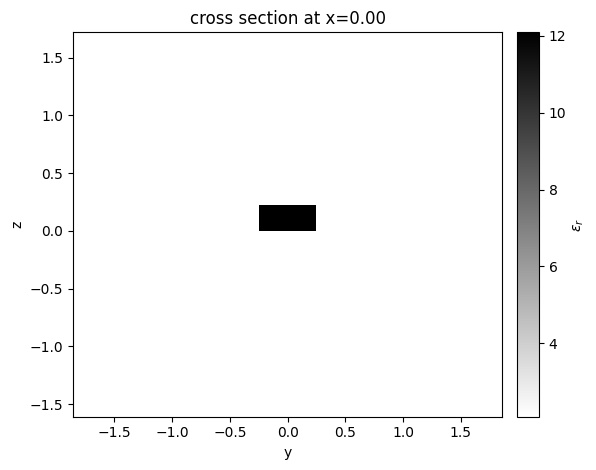

In [6]:
mode_solver_example = silicon_waveguide_mode_solver(w=0.5)
mode_solver_example.plot_eps()
plt.show()

The mode solving is done for the waveguide width from 220 nm to 500 nm. Instead of running the mode solving sequentially, we run them in parallel through a batch to maximize the time saving.

In [7]:
w_list = np.linspace(h, 0.5, 8)  # range of the waveguide width to be studied

# generate a list of mode solvers
silicon_waveguide_mode_solvers = [silicon_waveguide_mode_solver(w) for w in w_list]

In [8]:
# run mode solvers in parallel
silicon_waveguide_batch_results = run_batch(
    mode_solvers=silicon_waveguide_mode_solvers,  # list of mode solvers
    task_name="silicon waveguides",  # each task in the batch will have a unique index appended to this base name
    folder_name="Mode Solver",  # name of the folder where tasks are stored on the server's web UI.
    results_files=[
        f"./data/w_{w:.2f}.hdf5" for w in w_list
    ],  # list of file paths where the results are downloaded
)

13:15:35 UTC Running a batch of 8 mode solvers.                                 
             

Output()

13:16:19 UTC A batch of `ModeSolver` tasks completed successfully!

We are mainly interested in the effective index of the fundamental mode. However we can also visualize the mode profile. For example, here we visualize the mode profile from one of the mode solvers. 

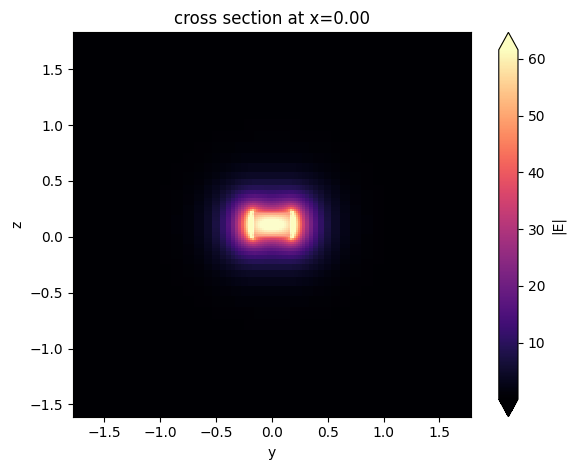

In [9]:
silicon_waveguide_mode_solvers[3].plot_field("E", "abs")
plt.show()

Extract and plot the effective index as a function of the waveguide width.

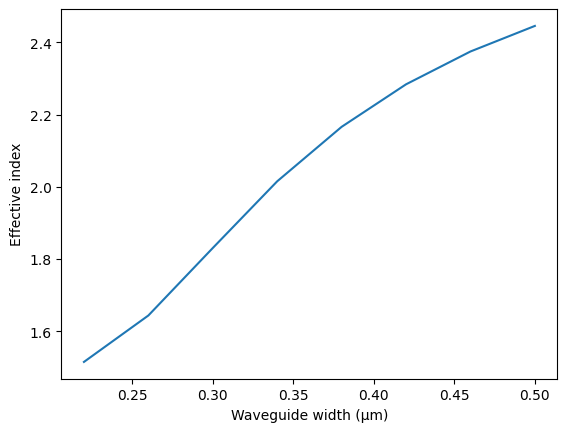

In [10]:
# extract the effective index of the fundamental mode
n_eff_silicon = np.zeros(len(w_list))
for i, result in enumerate(silicon_waveguide_batch_results):
    n_eff_silicon[i] = result.n_eff[0][0].values

plt.plot(w_list, n_eff_silicon)
plt.xlabel("Waveguide width (μm)")
plt.ylabel("Effective index")
plt.show()

Next we will perform the same analysis for the plasmonic waveguide. A few things to note here: 

1. The slot mode has a strong field inside the small slot region and near the metal surface. To ensure the effective index is accurate, we need to use a fine grid resolution. Here we use the automatic nonuniform grid with `min_steps_per_wvl=50` mainly for convenience. Alternatively, one could consider using an overall coarser grid but add a mesh refinement region around the slot and metal. This approach can potentially reduce the total number of grid points and thus save some computational cost.

2. By default, we apply [staircasing](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Staircasing.html) for metal structures. For enhanced accuracy, we can turn on [volumetric averaging](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.VolumetricAveraging.html) for metal.

3. For the same reason, we use double precision instead of the default single precision in the mode solver.

In [11]:
# define a function to create plasmonic waveguide mode solver
def plasmonic_waveguide_mode_solver(p):

    # define the waveguide left to the slot
    slot_left = td.Structure(
        geometry=td.Box(center=(-(s + p) / 2, 0, 0), size=(p, t, td.inf)), medium=ag
    )

    # define the waveguide right to the slot
    slot_right = td.Structure(
        geometry=td.Box(center=((s + p) / 2, 0, 0), size=(p, t, td.inf)), medium=ag
    )

    # define mode solving plane size
    mode_plane_size_x = 2 * (2 * p + s)
    mode_plane_size_y = 6 * t

    # define a simulation
    sim = td.Simulation(
        size=(mode_plane_size_x, mode_plane_size_y, 1),
        grid_spec=td.GridSpec.auto(
            min_steps_per_wvl=50, wavelength=lda0
        ),  # fine grid resolution is used to ensure accurate result
        structures=[slot_left, slot_right],
        run_time=1e-12,
        medium=sio2,
        subpixel=td.SubpixelSpec(
            metal=td.VolumetricAveraging()
        ),  # enable volumetric averaging for metal for improved accuracy
    )

    # define a mode solver
    mode_solver = ModeSolver(
        simulation=sim,
        plane=td.Box(size=(mode_plane_size_x, mode_plane_size_y, 0)),
        mode_spec=td.ModeSpec(
            num_modes=1, precision="double", target_neff=3
        ),  # use double precision
        freqs=[freq0],
    )

    return mode_solver

Again we create an example mode solver and visualize it. More importantly, we inspect the grid to ensure resolution is sufficiently fine.

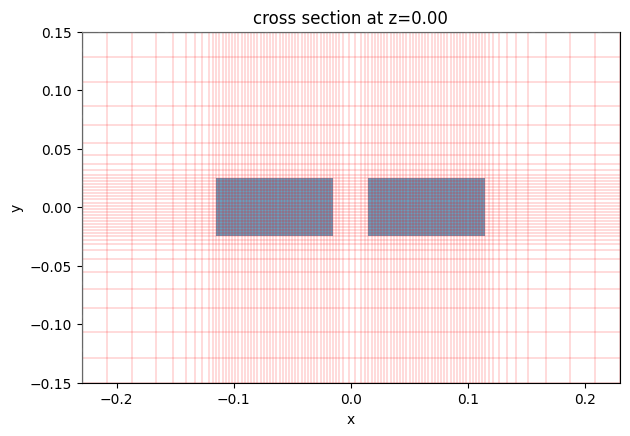

In [12]:
mode_solver_example = plasmonic_waveguide_mode_solver(p=0.1)
ax = mode_solver_example.plot()
mode_solver_example.plot_grid(ax=ax, colors="r")
plt.show()

Here the mode solving is done for the waveguide width from 50 nm to 500 nm.

In [13]:
p_list = np.linspace(0.05, 0.5, 9)  # range of the plasmonic waveguide width

# create a list of mode solvers
plasmonic_waveguide_mode_solvers = [plasmonic_waveguide_mode_solver(p) for p in p_list]

# run mode solvers in parallel
plasmonic_waveguide_batch_results = run_batch(
    mode_solvers=plasmonic_waveguide_mode_solvers,  # list of mode solvers
    task_name="plasmonic waveguides",  # each task in the batch will have a unique index appended to this base name
    folder_name="Mode Solver",  # name of the folder where tasks are stored on the server's web UI.
    results_files=[
        f"./data/p_{p:.2f}.hdf5" for p in p_list
    ],  # list of file paths where the results are downloaded
)

13:16:21 UTC Running a batch of 9 mode solvers.                                 
             

Output()

13:16:45 UTC A batch of `ModeSolver` tasks completed successfully!

Plot the mode profile of a mode solver to ensure we are looking at the correct slot mode.

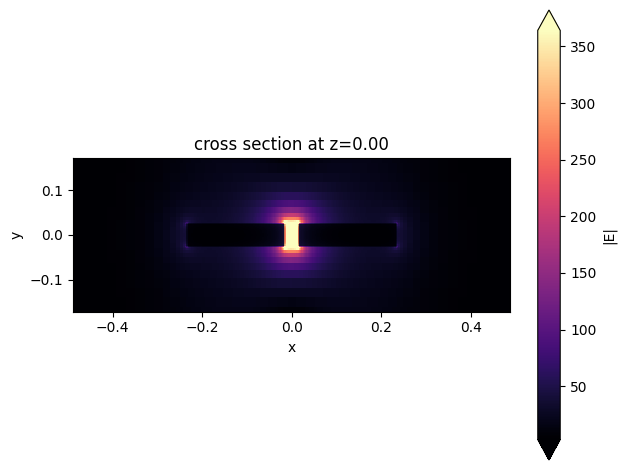

In [14]:
plasmonic_waveguide_mode_solvers[3].plot_field("E", "abs")
plt.show()

To help the analysis, we plot the effective indices of both the silicon waveguide and the plasmonic waveguide together, similar to Fig. 2(a) of the referenced [paper](https://doi.org/10.1364/OE.25.016214).

From this plot, we can determine the silicon waveguide width and the plasmonic waveguide width given a target effective index. The option is seemingly infinite as for any effective index between ~2.1 and ~2.5, we can identify a `w` and a `p` such that the mode indices are equal. 

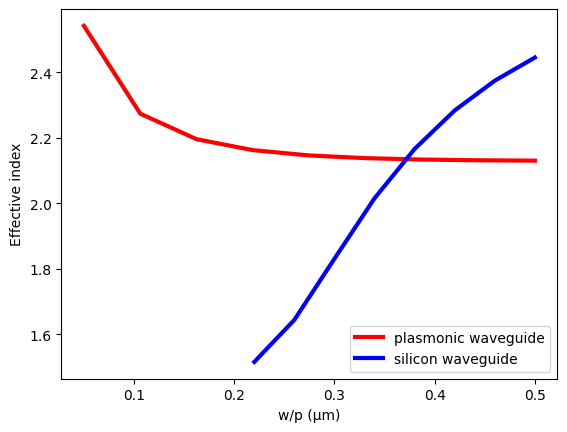

In [15]:
# extract the effective index of the fundamental mode
n_eff_plasmonic = np.zeros(len(p_list))
for i, result in enumerate(plasmonic_waveguide_batch_results):
    n_eff_plasmonic[i] = result.n_eff[0][0].values

# plot the effective indices of the silicon waveguide and plasmonic waveguide
plt.plot(p_list, n_eff_plasmonic, c="red", linewidth=3, label="plasmonic waveguide")
plt.plot(w_list, n_eff_silicon, c="blue", linewidth=3, label="silicon waveguide")

plt.xlabel("w/p (μm)")
plt.ylabel("Effective index")
plt.legend()
plt.show()

In fact, for optimal result, we cannot use an arbitrary target effective index. Since the plasmonic waveguide is lossy, we prefer to shorten the coupling region length as much as possible to minimize the absorption loss. Therefore, we need to analyze the optimal coupling length for different effective index values. This can be done by performing a normal mode analysis for the hybrid waveguide cross section. According to the normal mode analysis, the optimal coupling length is then given by $L_c = \frac{\lambda}{2(n_1-n_2)}$, where $n_1$ and $n_2$ are the effective indices of the first and second normal modes. 

In [16]:
# define a function to create hybrid waveguide mode solver
def hybrid_waveguide_mode_solver(n_eff):

    w = np.interp(
        n_eff, n_eff_silicon, w_list
    )  # determine the silicon waveguide width given the effective index
    p = np.interp(
        n_eff, np.flipud(n_eff_plasmonic), np.flipud(p_list)
    )  # determine the plasmonic waveguide width given the effective index
    g = 0.08  # gap size between the silicon waveguide and the plasmonic waveguide

    # create the plasmonic waveguide structures
    slot_left = td.Structure(
        geometry=td.Box(center=(-(s + p) / 2, h / 2 + g + t / 2, 0), size=(p, t, td.inf)), medium=ag
    )
    slot_right = td.Structure(
        geometry=td.Box(center=((s + p) / 2, h / 2 + g + t / 2, 0), size=(p, t, td.inf)), medium=ag
    )

    # create the silicon waveguide structure
    silicon_waveguide = td.Structure(geometry=td.Box(size=(w, h, td.inf)), medium=si)

    # mode solving plane size
    mode_plane_size_x = 2 * (2 * p + s + w)
    mode_plane_size_y = 3 * (t + g + h)

    # create a simulation
    sim = td.Simulation(
        size=(mode_plane_size_x, mode_plane_size_y, 1),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=50, wavelength=lda0),
        structures=[silicon_waveguide, slot_left, slot_right],
        run_time=1e-12,
        medium=sio2,
        subpixel=td.SubpixelSpec(metal=td.VolumetricAveraging()),
        symmetry=(-1, 0, 0),  # use symmetry that is compatible with the fundamental TE mode
    )

    # create a mode solver
    mode_solver = ModeSolver(
        simulation=sim,
        plane=td.Box(size=(mode_plane_size_x, mode_plane_size_y, 0)),
        mode_spec=td.ModeSpec(num_modes=2, precision="double", target_neff=3),  # solve for 2 modes
        freqs=[freq0],
    )

    return mode_solver

Create an example mode solver to visualize the setup. We correctly see the silicon waveguide with the plasmonic waveguide on top of it. 

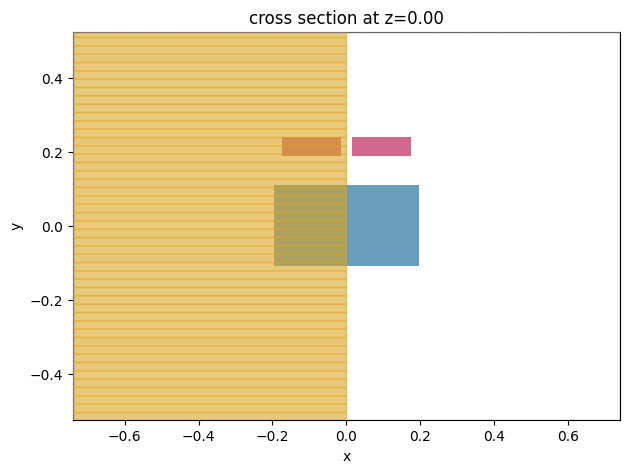

In [17]:
mode_solver_example = hybrid_waveguide_mode_solver(n_eff=2.2)
mode_solver_example.plot()
plt.show()

Now we perform mode solving for a range of target effective indices from 2.15 to 2.5. 

In [18]:
n_eff_list = np.linspace(2.15, 2.5, 8)  # effective index range

# create a list of mode solvers
hybrid_waveguide_mode_solvers = [hybrid_waveguide_mode_solver(n_eff) for n_eff in n_eff_list]

# run mode solvers in parallel
hybrid_waveguide_batch_results = run_batch(
    mode_solvers=hybrid_waveguide_mode_solvers,  # list of mode solvers
    task_name="hybrid waveguides",  # each task in the batch will have a unique index appended to this base name
    folder_name="Mode Solver",  # name of the folder where tasks are stored on the server's web UI.
    results_files=[
        f"./data/n_eff_{n_eff:.2f}.hdf5" for n_eff in n_eff_list
    ],  # list of file paths where the results are downloaded
)

13:16:47 UTC Running a batch of 8 mode solvers.                                 
             

Output()

13:17:15 UTC A batch of `ModeSolver` tasks completed successfully!

Compute and plot the coupling length as a function of the effective index. The coupling length is found to increase with the effective index. Therefore, a lower refractive index is preferred to minimize absorption loss. 

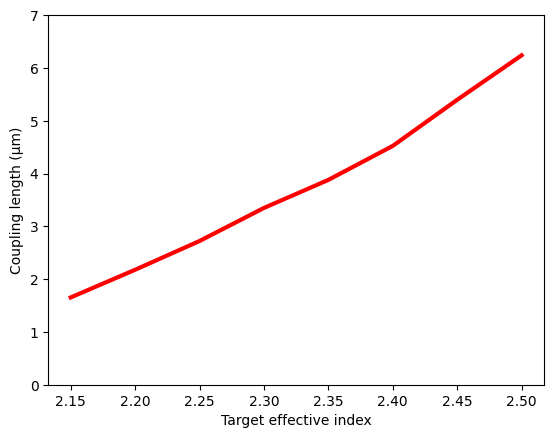

In [19]:
# compute the coupling length based on the normal mode effective indices
L_c = np.zeros(len(n_eff_list))
for i, result in enumerate(hybrid_waveguide_batch_results):
    n_1 = result.n_eff.sel(mode_index=0).values[0]
    n_2 = result.n_eff.sel(mode_index=1).values[0]

    L_c[i] = lda0 / (2 * (n_1 - n_2))

# plot the coupling length
plt.plot(n_eff_list, L_c, c="red", linewidth=3)
plt.ylim(0, 7)
plt.xlabel("Target effective index")
plt.ylabel("Coupling length (μm)")
plt.show()

## FDTD Verification of the Coupling Efficiency

We use the target effective index of 2.15. The corresponding silicon waveguide and plasmonic waveguide widths can be calculated by simple interpolation. The optimal coupling length from this analysis turns out to be around 1.65 μm. We will verify the coupling efficiency using FDTD. To do so, we define a [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation) with a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) as excitation and two [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) instances to measure the coupling efficiency and return loss. To help with visualization, we also use a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) in the $yz$ plane.

To ensure accuracy, again we use a fine grid resolution and turn on the volumetric averaging for metal. In addition, to make the simulation domain as compact as possible and prevent simulation divergence, we use the [Absorber](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Absorber.html) boundary condition instead of the default [PML](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PML.html). The simulation can diverge is a dispersive medium is inside PML or the distance between the structure and PML is too close. To minimize the artificial reflection of the absorber, we increase the number of layers to `60` in the $z$ direction.

In [20]:
target_n_eff = 2.15
w = np.interp(
    target_n_eff, n_eff_silicon, w_list
)  # calculate the silicon waveguide width given the target effective index
p = np.interp(
    target_n_eff, np.flipud(n_eff_plasmonic), np.flipud(p_list)
)  # calculate the plasmonic waveguide width given the target effective index
L_c_opt = np.interp(
    target_n_eff, n_eff_list, L_c
)  # calculate the coupling length given the target effective index

print(f"Silicon waveguide width is {w*1e3:.2f} nm.")
print(f"Plasmonic waveguide width is {p*1e3:.2f} nm")
print(f"Optimal coupling length is {L_c_opt*1e3:.2f} nm")

g = 0.08  # gap size between the silicon waveguide and the plasmonic waveguide
inf_eff = 1e3  # effective infinity
buffer = lda0 / 2  # buffer spacing for padding the simulation domain

# define both waveguide structures
slot_left = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-s / 2 - p, h / 2 + g, 0), rmax=(-s / 2, h / 2 + g + t, inf_eff)
    ),
    medium=ag,
)

slot_right = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(s / 2, h / 2 + g, 0), rmax=(s / 2 + p, h / 2 + g + t, inf_eff)
    ),
    medium=ag,
)

silicon_waveguide = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-w / 2, -h / 2, -inf_eff), rmax=(w / 2, h / 2, L_c_opt)),
    medium=si,
)

# define a mode source
mode_spec = td.ModeSpec(num_modes=1, target_neff=3)
mode_source = td.ModeSource(
    center=(0, 0, -buffer / 2),
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# add a mode monitor to measure transmission at the plasmonic waveguide
mode_monitor_t = td.ModeMonitor(
    center=(0, 0, L_c_opt + buffer / 2),
    size=(td.inf, td.inf, 0),
    freqs=freqs,
    mode_spec=mode_spec,
    name="T",
)

# add a mode monitor to measure reflection at the silicon waveguide
mode_monitor_r = td.ModeMonitor(
    center=(0, 0, -0.75 * buffer),
    size=(td.inf, td.inf, 0),
    freqs=freqs,
    mode_spec=mode_spec,
    name="R",
)

# add a field monitor to visualize field distribution
field_monitor = td.FieldMonitor(
    size=(0, td.inf, td.inf), freqs=[freq0], interval_space=(1, 2, 4), name="field"
)

run_time = 5e-13  # simulation run time

# construct simulation
sim_coupler = td.Simulation(
    center=(0, h / 2, L_c_opt / 2),
    size=(2 * (2 * p + s + w), 3 * (t + g + h), L_c_opt + 2 * buffer),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=50, wavelength=lda0),
    structures=[slot_left, slot_right, silicon_waveguide],
    sources=[mode_source],
    monitors=[mode_monitor_r, mode_monitor_t, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.absorber(), y=td.Boundary.absorber(), z=td.Boundary.absorber(num_layers=60)
    ),  # using a larger number of layers to minimize reflection
    subpixel=td.SubpixelSpec(
        metal=td.VolumetricAveraging()
    ),  # turn on volumetric averaging for metal
    medium=sio2,
    symmetry=(-1, 0, 0),
)

sim_coupler.plot_3d()

Silicon waveguide width is 375.74 nm.
Plasmonic waveguide width is 261.83 nm
Optimal coupling length is 1652.90 nm


Since a fine grid resolution is used, we would like to estimate the cost before running the simulation to ensure it's affordable.

In [21]:
job = web.Job(simulation=sim_coupler, task_name="coupling")
estimated_cost = web.estimate_cost(job.task_id)

13:17:16 UTC Created task 'coupling' with task_id                               
             'fdve-571ca63d-c81f-455d-8e51-71212972b050' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=92354;https://tidy3d.simulation.cloud/workbench?taskId=fdve-571ca63d-c81f-455d-8e51-71212972b050\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=240277;https://tidy3d.simulation.cloud/workbench?taskId=fdve-571ca63d-c81f-455d-8e51-71212972b050\taskId]8;;\]8;id=92354;https://tidy3d.simulation.cloud/workbench?taskId=fdve-571ca63d-c81f-455d-8e51-71212972b050\=]8;;\]8;id=715796;https://tidy3d.simulation.cloud/workbench?taskId=fdve-571ca63d-c81f-455d-8e51-71212972b050\fdve]8;;\]8;id=92354;https://tidy3d.simulation.cloud/workbench?taskId=fdve-571ca63d-c81f-455d-8e51-71212972b050\-571ca63d-c81]8;;\
             ]8;id=92354;https://tidy3d.simulation.cloud/workbench?taskId=fdve-571ca63d-c81f-455d-8e51-71212972b050\f-455d-8e51-71212972b050']8;;\.

Output()

13:17:18 UTC Maximum FlexCredit cost: 2.521. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Run the simulation after the cost is checked.

In [22]:
sim_data_coupler = job.run(path="data/simulation_data.hdf5")

13:17:25 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

13:17:30 UTC status = preprocess

13:17:33 UTC Maximum FlexCredit cost: 2.521. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

13:17:34 UTC running solver

Output()

13:19:57 UTC early shutoff detected at 64%, exiting.

13:19:58 UTC status = postprocess

Output()

13:20:23 UTC status = success

13:20:24 UTC View simulation result at                                          
             ]8;id=212537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-571ca63d-c81f-455d-8e51-71212972b050\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=163045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-571ca63d-c81f-455d-8e51-71212972b050\taskId]8;;\]8;id=212537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-571ca63d-c81f-455d-8e51-71212972b050\=]8;;\]8;id=540109;https://tidy3d.simulation.cloud/workbench?taskId=fdve-571ca63d-c81f-455d-8e51-71212972b050\fdve]8;;\]8;id=212537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-571ca63d-c81f-455d-8e51-71212972b050\-571ca63d-c81]8;;\
             ]8;id=212537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-571ca63d-c81f-455d-8e51-71212972b050\f-455d-8e51-71212972b050']8;;\.

Output()

13:20:25 UTC loading simulation from data/simulation_data.hdf5

After the simulation is finished, extract and plot the coupling efficiency and return loss from 1500 nm to 1600 nm. We see a good coupling efficiency of around 1 dB across the entire wavelength range and a very low return loss, indicating efficient coupling. 

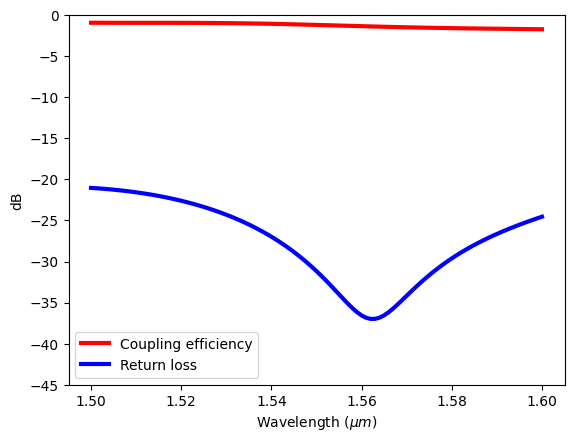

In [23]:
# extract the transmission data from the mode monitor
T = np.abs(sim_data_coupler["T"].amps.sel(mode_index=0, direction="+")) ** 2
R = np.abs(sim_data_coupler["R"].amps.sel(mode_index=0, direction="-")) ** 2

plt.plot(ldas, 10 * np.log10(T), c="red", linewidth=3, label="Coupling efficiency")
plt.plot(ldas, 10 * np.log10(R), c="blue", linewidth=3, label="Return loss")
plt.ylim(-45, 0)
plt.xlabel("Wavelength ($\mu m$)")
plt.legend()
plt.ylabel("dB")
plt.show()

Plot the field distribution to visualize the coupling.

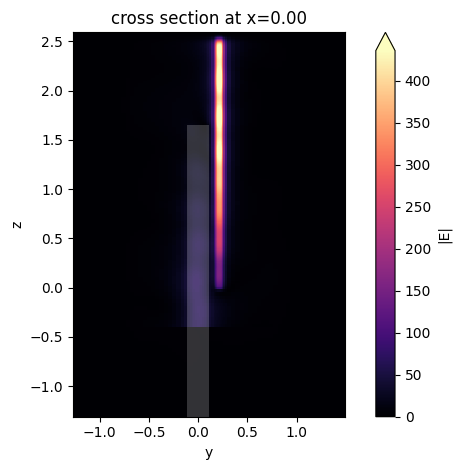

In [24]:
sim_data_coupler.plot_field(field_monitor_name="field", field_name="E", val="abs")
plt.show()

## Simulation of the Plasmonic Antenna

Once the coupling region design is complete, we move on to design the plasmonic antenna. In this case, we will explore the Vivaldi antenna design with exponential tapers. That is, the taper profile is described by $x = A e^{Rz} + B$, where $R$ determines the shape of the profile. 

The design and optimization of the antenna usually require a good amount of simulations, but for the sake of keeping the notebook short, we will skip the optimization procedure and only simulate the optimized design. The optimization can be done via parameter sweep or other optimization techniques as demonstrated in other examples in the [example library](https://www.flexcompute.com/tidy3d/learning-center/example-library/).

For the optimal design, the antenna length $L_a$ is 1.75 μm and $R$ is 3 μm$^{-1}$. We will first create the antenna structure and then simulate it. 

In [25]:
L_a = 1.75  # antenna length
R = 3  # shape parameter

# set up the system of equations
# s/2 = A * exp(R * L_c_opt) + B
# s/2+p = A * exp(R * (L_c_opt+L_a)) + B

# this can be written as a matrix equation:
# [exp(R * L_c_opt), 1] [A] = [s/2]
# [exp(R * (L_c_opt+L_a)), 1] [B] = [s/2+p]

# create the matrix
matrix = np.array([[np.exp(R * L_c_opt), 1], [np.exp(R * (L_c_opt + L_a)), 1]])

# create the right-hand side vector
vector = np.array([s / 2, s / 2 + p])

# solve the system of equations
A, B = np.linalg.solve(matrix, vector)

# function to compute the x coordinate of the exponential curve given the z coordinate
def compute_x(z):
    return A * np.exp(R * z) + B


n_pt = 100  # number of points for the polyslab

# compute the vertices for the left antenna arm
vertices = [[compute_x(z), z] for z in np.linspace(L_c_opt, L_c_opt + L_a, n_pt)]
vertices.append([s / 2 + p, L_c_opt])

# create the left antenna arm structure
antenna_left = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=1, slab_bounds=(h / 2 + g, h / 2 + g + t)),
    medium=ag,
)

# similarly for the right antenna arm
vertices = [[-compute_x(z), z] for z in np.linspace(L_c_opt, L_c_opt + L_a, n_pt)]
vertices.append([-s / 2 - p, L_c_opt])
antenna_right = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=1, slab_bounds=(h / 2 + g, h / 2 + g + t)),
    medium=ag,
)

# create the plasmonic waveguide structures
slot_left = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-s / 2 - p, h / 2 + g, 0), rmax=(-s / 2, h / 2 + g + t, L_c_opt)
    ),
    medium=ag,
)

slot_right = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(s / 2, h / 2 + g, 0), rmax=(s / 2 + p, h / 2 + g + t, L_c_opt)
    ),
    medium=ag,
)

To ensure the antenna structure is created correctly, we can plot the shape and visualize it.

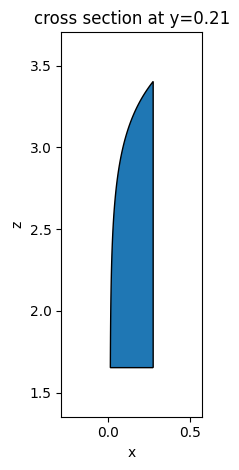

In [26]:
antenna_left.plot(y=h / 2 + g + t / 2)
plt.show()

To investigate the performance of the antenna, we need to perform near field to far field projection using the [FieldProjectionAngleMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldProjectionAngleMonitor.html). More specifically, we want to calculate the antenna directivity in the E-plane and H-plane. Therefore, we focus on `phi=0` and `phi=pi/2` respectively, where `phi` is the azimuth angles with respect to the global z axis. Note that the field projection monitor encloses the antenna but intersects the silicon waveguide. We require the surfaces of the field projection monitor to be in uniform medium only. To get around this, we set `exclude_surfaces` to `["z-"]`. This way, the surface in the $z-$ direction is ignored in the calculation. This will introduce a small inaccuracy as some radiation in that direction is not captured. However, for the antenna, we are mainly interested in the forward radiation so this inaccuracy is acceptable. 

For the directivity calculation, we also need to know the total radiated power and thus we define a [FluxMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FluxMonitor.html) surrounding the antenna.

In [27]:
# create a FieldProjectionAngleMonitor to perform the near field to far field transformation in spherical coordinates
theta_array = np.linspace(0, 2 * np.pi, 200)  # theta angle range
phi_array = np.linspace(0, np.pi / 2, 2)  # phi angle range

# define the field projection monitor
n2f_monitor = td.FieldProjectionAngleMonitor(
    center=(0, h / 2, (L_c_opt + L_a) / 2),
    size=(2 * p + s + w, 2 * (t + g + h), L_c_opt + L_a + 1.2 * buffer),
    freqs=[freq0],
    name="n2f_monitor",
    custom_origin=(0, 0, 0),
    phi=phi_array,
    theta=theta_array,
    exclude_surfaces=["z-"],
)

# define a flux monitor to calculate the total radiated power
flux_monitor = td.FluxMonitor(
    center=n2f_monitor.center,
    size=n2f_monitor.size,
    freqs=[freq0],
    name="power",
)

Create the antenna simulation. The overall settings are similar to that of the coupler simulation.

In [28]:
# construct simulation
sim_antenna = td.Simulation(
    center=(0, h / 2, (L_c_opt + L_a) / 2),
    size=(2 * (2 * p + s + w), 3 * (t + g + h), L_c_opt + L_a + 2 * buffer),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=50, wavelength=lda0),
    structures=[slot_left, slot_right, antenna_right, antenna_left, silicon_waveguide],
    sources=[mode_source],
    monitors=[flux_monitor, n2f_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.absorber(),
        y=td.Boundary.absorber(),
        z=td.Boundary(plus=td.PML(), minus=td.Absorber(num_layers=60)),
    ),
    subpixel=td.SubpixelSpec(metal=td.VolumetricAveraging()),
    medium=sio2,
    symmetry=(-1, 0, 0),
)

13:20:35 UTC WARNING: Structure at structures[2] was detected as being less than
             half of a central wavelength from a PML on side z-max. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 1 WARNING message.                             

Visualize the simulation in 3D.

In [29]:
sim_antenna.plot_3d()

Submit the simulation to the cloud. The cost of this simulation will be slightly higher than that of the previous simulation due to its larger simulation domain. 

In [30]:
sim_data_antenna = web.run(simulation=sim_antenna, task_name="antenna")

             Created task 'antenna' with task_id                                
             'fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=318170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=466837;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2\taskId]8;;\]8;id=318170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2\=]8;;\]8;id=117321;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2\fdve]8;;\]8;id=318170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2\-4b61605b-083]8;;\
             ]8;id=318170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2\c-4818-8c8c-1401e6d4afb2']8;;\.

Output()

13:20:38 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

13:20:43 UTC status = preprocess

13:20:47 UTC Maximum FlexCredit cost: 3.214. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

13:23:00 UTC early shutoff detected at 80%, exiting.

             status = postprocess

Output()

13:23:02 UTC status = success

13:23:03 UTC View simulation result at                                          
             ]8;id=82686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=745090;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2\taskId]8;;\]8;id=82686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2\=]8;;\]8;id=993675;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2\fdve]8;;\]8;id=82686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2\-4b61605b-083]8;;\
             ]8;id=82686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b61605b-083c-4818-8c8c-1401e6d4afb2\c-4818-8c8c-1401e6d4afb2']8;;\.

Output()

             loading simulation from simulation_data.hdf5

             WARNING: Structure at structures[2] was detected as being less than
             half of a central wavelength from a PML on side z-max. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 1 WARNING message.                             

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

Calculate and plot the antenna directivity in the E-plane and H-plane. We see a strong forward radiation with a directivity over 12 (~11 dB). 

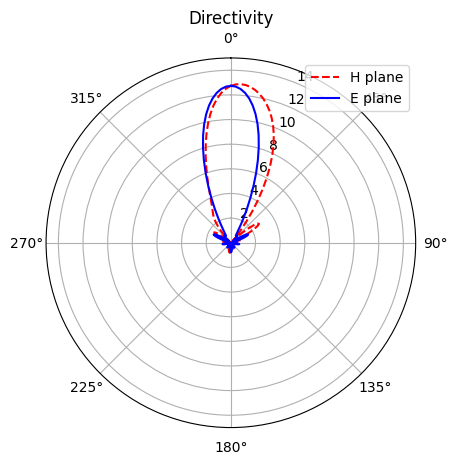

In [31]:
P0 = np.array(sim_data_antenna["power"].flux)  # total radiated power of the antenna

# angular radiated power of the antenna
# by default, the power is calculated at 1 meter away from the antenna. 
# The 1e12 factor normalizes the power to unit distance (1 um)
P_e = np.squeeze(
    1e12 * sim_data_antenna["n2f_monitor"].power.sel(f=freq0, phi=0, method="nearest").values
)
D_e = 4 * np.pi * P_e / P0  # directivity of the antenna

P_h = np.squeeze(
    1e12
    * sim_data_antenna["n2f_monitor"].power.sel(f=freq0, phi=np.pi / 2, method="nearest").values
)
D_h = 4 * np.pi * P_h / P0  # directivity of the antenna

# plot the directivity in the E-plane and H-plane
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
ax.plot(theta_array, D_h, c="red", linestyle="--", label="H plane")
ax.plot(theta_array, D_e, c="blue", label="E plane")
ax.set_rlim(0, 15)
ax.set_title("Directivity")
ax.legend()
plt.show()

The result confirms that the antenna design works well. In the referenced [paper](https://doi.org/10.1364/OE.25.016214), an optical wireless link simulation is performed where two antennas are separated over a long distance. One antenna functions as the transmitter while the other antenna functions as a receiver. The same power budget analysis can also be done via the Friis transmission equation. 